# Fluidinámica computacional (Sesión 02)


<img src="figures/LogoCinvestav.png" style="height:100px" title="Cinvestav">


**CINVESTAV Unidad Saltillo**

**Programa de Maestría en Ciencias en Ingeniería Metalúrgica**

Dr. Edgar Ivan Castro Cedeño


Contacto:
[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [1]:
using Plots
using LaTeXStrings

# Detalles adicionales

## Interpolación de la conductividad térmica en las caras

En la discretización de la ecuación de conducción de calor, el flujo de calor se evalúa en las caras entre volúmenes de control adyacentes.

Consecuentemente, se debe especificar el valor de la conductividad térmica en las caras entre celdas adyacentes, $\lambda_f$.

<center>

<img src="figures/images/interpolationThermalConductivity_py.png" style="width:400px" title="Discretización 1D">

***Figura 01. Discretización espacial considerada para la interpolación de la conductividad térmica en la cara entre celdas adyacentes, $\lambda_e$.***

</center>

<details>
<summary><b>Pie de Figura</b></summary>

<div class="alert alert-info">

El esquema presenta dos nodos de celda posicionados sobre el eje horizontal, $P$, y $E$. Cada uno representa una posición geométrica dentro de un volumen de control individual; i.e., en el esquema se muestran los nodos de dos volúmenes de control.
	
El nodo de superficie, $e$, indica la posición de las interfaces entre los volúmenes de control adyacentes, $P$ y $E$.

- La posición del nodo de superficie, $e$, no necesariamente esta a media distancia entre los nodos de celda, $P$ y $E$.
	
La superficie de la cara en la interfaz esta dada por $A_e$. La flecha roja representa un vector normal a la superficie de la cara entre celdas adyacentes.
	
Distancias entre nodos:
	
- La distancia entre nodos de celda, $\overline{PE} = (\delta x)_e$.
	
- La distancia entre el nodo de celda y el nodo de cara, $\overline{Pe}=(\delta x)_{e-}.$
	
- La distancia entre el nodo de cara y el nodo de celda, $\overline{eE}=(\delta x)_{e+}.$
	
La conductividad térmica en los nodos de celda esta dada por $\lambda_P$ y $\lambda_E$. 

La conductividad térmica en la cara adyacente esta dada por $\lambda_e$.

</div>

</details>

La conductividad térmica en la cara, $\lambda_e$, es interpolada utilizando la media armónica de $\lambda_P$ y $\lambda_E$:

$$\lambda_e = \left( \frac{f_{e-}}{\lambda_P} + \frac{f_{e+}}{\lambda_E}  \right)^{-1}$$

$$f_{e-} + f_{e+} = 1$$

<details>
<summary><b>Nomenclatura</b></summary>

<div class="alert alert-info">

$$f_{e-} = \frac{(\delta x)_{e-}}{(\delta x)_{e}}$$

$$f_{e+} = \frac{(\delta x)_{e+}}{(\delta x)_{e}}$$

</div>

</details>

### Análisis de la función de interpolación

Debajo se escribe una implementación de la función de interpolación para la conductividad térmica equivalente en la cara entre dos celdas adyacentes, $\lambda_e$

En la notación se consideran dos celdas adyacentes: una a la izquierda (left) y una a la derecha (right).

$$\lambda_e = \left( \frac{f_{L}}{\lambda_L} + \frac{f_{R}}{\lambda_R}  \right)^{-1}$$

$$f_L + f_R = 1$$

In [2]:
function lambHarm(λₗ, λᵣ, fᵣ)
	fₗ = @. 1-fᵣ
	λₑ = @. 1 / (fₗ/λₗ + fᵣ/λᵣ)
	return λₑ
end

lambHarm (generic function with 1 method)

Para fines ilustrativos, también se considera una función de interpolación considerando un perfil lineal.

$$\lambda_e = f_L \lambda_L + f_R \lambda_R$$

In [3]:
function lambLin(λₗ, λᵣ, fᵣ)
	fₗ = @. 1-fᵣ
	λₑ = @. λₗ*fₗ + λᵣ*(fᵣ)
	return λₑ
end

lambLin (generic function with 1 method)

In [4]:
# parametrización
Δf = 0.25 # paso para discretización de f
λₗ = 10.0 # conductividad térmica a la izquierda [W.m-1.K-1]
λᵣ = 1.0 # conductividad térmica a la derecha [W.m-1.K-1]

1.0

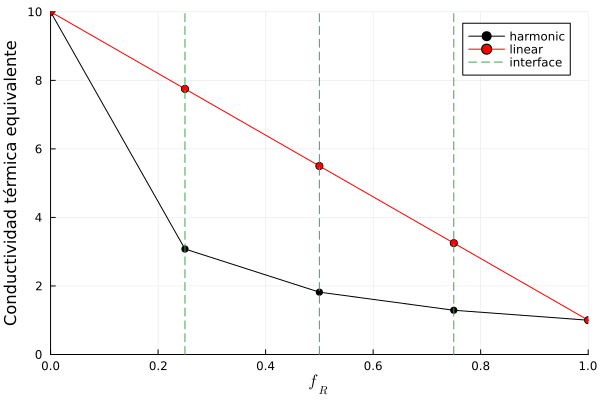

In [5]:
# Mallado y conductividad térmica equivalente
f = collect(0.0:Δf:1.0)
λₑ =  lambHarm(λₗ, λᵣ, f) # media harmónica
λ₁ = lambLin(λₗ, λᵣ, f)  # perfil lineal

plot(f, λₑ, linestyle=:solid, marker=:circle, color=:black, label="harmonic")
plot!(f, λ₁, linestyle=:solid, marker=:circle, color=:red, label="linear")
vline!(f[2:end-1], linestyle=:dash, label="interface")
xlims!(0, 1)
ylims!(0, maximum([λₗ, λᵣ]))
xlabel!(L"f_{R}")
ylabel!("Conductividad térmica equivalente")

### Ejercicio

Al igual que cualquier propiedad o campo, se debe elegir una función de interpolación apropiada para la conductividad térmica en las caras.

Muestre el razonamiento físico tras la utilización de la media armónica para la interpolación de la conductividad térmica en la cara, $\lambda_e$.

<details>
<summary><b>Respuesta</b></summary>

<div class="alert alert-success">

**Razonamiento físico para la utilización de la media armónica**

 Considerando el esquema arriba, el flujo de calor en la cara $A_e$ esta dado por: 

 $$-\mathbf{q_e \cdot A_e} = \lambda \left(\frac{dT}{dx} \right)_e$$

Que se puede aproximar considerando un perfil de temperatura lineal entre celdas:

 $$-\mathbf{q_e \cdot A_e} \approx  \frac{\lambda_e}{(\delta x)_e} (T_E - T_P)$$

 Que a su vez se puede escribir en términos de una resistencia térmica equivalente en una pared compuesta, $R_T$:

 $$-\mathbf{q_e \cdot A_e} \approx  - \frac{(T_E - T_P)}{R_T}$$

 Donde

 $$R_T = \frac{(\delta x)_e}{\lambda_e} = \frac{(\delta x)_{e-}}{\lambda_P} + \frac{(\delta x)_{e+}}{\lambda_E}$$

 Aislando $\lambda_e$ del lado izquierdo de la ecuación:

 $$\frac{1}{\lambda_e} = \frac{{(\delta x)_{e-}}}{(\delta x)_{e}} \left( \frac{1}{\lambda_P} \right) + \frac{{(\delta x)_{e+}}}{(\delta x)_{e}} \left( \frac{1}{\lambda_E} \right)$$

 Realizando el cambio de notación: 
 
 $$f_{e-} = \frac{(\delta x)_{e-}}{(\delta x)_{e}}$$
 
 $$f_{e+} = \frac{(\delta x)_{e+}}{(\delta x)_{e}}$$
 
 Sustituyendo en la ecuación:

 $$\frac{1}{\lambda_e} = \frac{f_{e-}}{\lambda_P} + \frac{f_{e+}}{\lambda_E}$$

 $$\lambda_e = \left( \frac{f_{e-}}{\lambda_P} + \frac{f_{e+}}{\lambda_E}  \right)^{-1}$$

</div>
</details>

### Ejercicio

¿Por qué la utilización de un perfil lineal para la estimación de la conductividad térmica en las caras no es recomendable?

<details>
<summary><b>Respuesta</b></summary>

<div class="alert alert-success">

**Comentarios sobre la utilización de un perfil lineal para estimar conductividad térmica en las caras**



</div>
</details>

## Linealización del término fuente

Una de las reglas para asegurar criterios de estabilidad numérica es que la pendiente del término fuente linealizado sea negativa o igual a cero, para asegurar que los coeficientes $a_P$ sean positivos.

$$\bar{S} = S_C + S_P T_P$$

$$a_P = \sum a_n - S_P V$$

$$S_P \le 0$$

A continuación se discuten, mediante la utilización de ejemplos, estrategias para asegurar este criterio.

<div class="alert alert-info">

**Nomenclatura:**

En los ejemplos dados, $T_P^*$ es la temperatura calculada en la iteración previa del método numérico. 
	
De forma general, se considera que una variable que tiene un asterisco como superíndice, por ejemplo ${\phi}^*$, corresponde al valor obtenido en una iteración previa del método numérico.

</div>

### Ejemplo 1

Considerando el termino fuente: 

$$S = 5 - 4T$$

algunas posibles linealizaciones son:

1. La linealización mas obvia, **que en este ejemplo es la recomendada**.

$$S = \underbrace{5}_{S_C} \underbrace{- 4}_{S_P}T$$


$$S_C = 5$$

$$S_P=-4$$

2. Considerar la totalidad del termino fuente en el termino constante.

    En la ecuación de $S_C$,  el termino $T_P^*$ es la temperatura calculada en la iteracion previa. 



$$S = \underbrace{5 - 4 T_P^*}_{S_C}$$

$$S_C = 5 - 4 T_P^*$$

$$S_P = 0$$

<div class="alert alert-warning">

Si la expresión de $S$ es complicada, esta podría ser la única opción.

</div>

3. Proponer una relación $S \sim T$ con pendiente mas pronunciada que la original. 

    En este caso la convergencia de las iteraciones es mas lenta. 

$$S = \underbrace{5 + 7 T_P^*}_{S_C} \underbrace{- 11}_{S_P} T$$

$$S_C = 5 + 7 T_P^*$$
$$S_P = -11$$

<div class="alert alert-warning">

Esto puede ser deseable en el caso que el problema presente otras no-linealidades.

</div>

### Ejemplo 2

Considerando el termino fuente: 

$$S = 3 + 7T$$

algunas posibles linealizaciones son:

1. La linealización mas obvia, **que no es aceptable porque $S_P > 0$**.

$$S = \underbrace{3}_{S_C} \underbrace{+7}_{S_P} T$$

$$S_C = 3$$

$$S_P=7$$

<div class="alert alert-danger">

Para el caso en que el problema pueda resolverse por un **método directo**, esta linealización daría la solución correcta.

Para el caso en que el problema se resuelva mediante un **método iterativo**, si $S_P>0$, puede ocurrir divergencia durante el proceso de obtención de la solución.

</div>

2. Considerar la totalidad del termino fuente en el termino constante. 

    En la ecuación de $S_C$,  el termino $T_P^*$ es la temperatura calculada en la iteración previa.
    
$$S = \underbrace{3 + 7 T_P^*}_{S_C}$$

$$S_C = 3 + 7 T_P^*$$

$$S_P = 0$$

<div class="alert alert-success">

Esta es la estrategia a seguir cuando no aparece de forma natural un termino $S_P$ negativo en la expresión original.

</div>

3. Creación de un termino artificial $S_P < 0$. En este caso la convergencia de las iteraciones es mas lenta. 

$$S = \underbrace{3 + 9 T_P^*}_{S_C} \underbrace{-2}_{S_P}T$$

$$S_C = 3 + 9 T_P^*$$

$$S_P = -2$$

<div class="alert alert-warning">

Esto puede ser deseable en el caso que el problema presente otras no-linealidades.

</div>

### Ejemplo 3

Considerando el termino fuente:

$$S = 4 - 5 T^3$$

algunas posibles linealizaciones son:

1. Considerar la totalidad del termino fuente en el termino constante de la ecuación linealizada.

    En la ecuación de $S_C$, $T_P^*$ es la temperatura calculada en la iteración previa. 

$$S = \underbrace{4 - 5 {T_P^*}^3}_{S_C}$$

$$S_C = 4 - 5 {T_P^*}^3$$

$$S_P = 0$$

<div class="alert alert-warning">

En este caso, esta estrategia no permite aprovechar de forma optima la dependencia entre $S$ y $T$.

</div>

2. Considerar la totalidad de la contribución no lineal del termino fuente, en el termino de la pendiente de la ecuación discretizada.  

    En la ecuación de $S_C$, $T_P^*$ es la temperatura calculada en la iteración previa.

$$S = \underbrace{4}_{S_C} \underbrace{-5 {T_P^*}^2}_{S_P} T$$

$$S_C = 4$$

$$S_P = -5 {T_P^*}^2$$

<div class="alert alert-danger">

Esta parece ser la linealización correcta, pero con esta estrategia la curva $S \sim T$ tiene una pendiente mas pronunciada que lo que pareciera.

</div>

3. Aproximación mediante una expansión con series de Taylor **(Método recomendado)**.

    En la ecuación de $S_C$, $T_P^*$ es la temperatura calculada en la iteración previa.

$$S = \underbrace{4 + 10 {T_P^*}^3}_{S_C} \underbrace{-15{T_P^*}^2}_{S_P} T$$

$$S_C = 4 + 10 {T_P^*}^3$$

$$S_P = -15{T_P^*}^2$$

<div class="alert alert-success">

**Aplicación de la aproximación mediante series de Taylor a la ecuación del ejemplo**

$$S = 4 - 5 T^3$$

$$\frac{dS}{dT} = -15 T^2$$

Sustituyendo en la serie de Taylor:

$$S = 4 - 5 {T_P^*}^3 - 15 {T_P^*}^2 \left( T - T_P^* \right)$$

Agrupando términos:

$$S = 4 - 5 {T_P^*}^3 + 15 {T_P^*}^3 -  15 {T_P^*}^2 T$$

$$S = \underbrace{4 + 10 {T_P^*}^3}_{S_C} \underbrace{-15{T_P^*}^2}_{S_P} T$$

</div>

4. Asignar de forma "arbitraria" el peso de los coeficientes. 
    
    En la ecuación de $S_C$, $T_P^*$ es la temperatura calculada en la iteración previa.

$$S = \underbrace{4 + 20 {T_P^*}^3}_{S_C} \underbrace{-25{T_P^*}^2}_{S_P} T$$

$$S_C = 4 + 20 {T_P^*}^3$$

$$S_P = -25{T_P^*}^2$$

<div class="alert alert-warning">

En este caso la la curva $S \sim T$ tiene una pendiente mas pronunciada y la convergencia es mas lenta.

</div>